# 1. Introduction & Imports

## 1.1. Problem Overview

The [Titanic competition in Kaggle](https://www.kaggle.com/competitions/titanic) is a classic among beginners in the Data Science & Machine Learning world.

It serves as an introduction to binary classification problems for supervised learning and typical data preprocessing challenges.

It is based on the horrible Titanic disaster which took place in 1912: the biggest ship at that time sank due to a collision with an iceberg, leaving thousands of deaths behind.

## 1.2. Problem Statement & Hypothesis

Our goal is to predict whether a list of passengers survived or not, given a dataset with useful information.

For each passenger, we need to return a variable that takes the value 1 if he survived and 0 if he did not.

Based on what we know, we assume the highest survival rates will be among women, children and wealthy passangers.

## 1.3. Evaluation Metrics

The Competition evaluates predictions based on accuracy.

For this reason, it makes sense we use the same metric when training and evaluating our model.

## 1.4. Dataset Description

We are given two csv files:

- One contains data from a list of passengers and we are told who survived and who did not. This is used for training our model.
- The other one has data on another list of passengers. We are not told who surviveed among them: we need to make predictions and submit it on the Competition.

## 1.5. Library Imports

Let's import all the libraries we will use:

In [1]:
import numpy as np
import pandas as pd
import os

import warnings

from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay, roc_curve, auc

# 2. Load & Explore Data

## 2.1. Load and Inspect Data

The following code reads the training and testing data and saves it as a Pandas DataFrame.

Let's also take a look at the first five rows of both the training and the testing data.

In [2]:
#Read csv files
df_train = pd.read_csv("/kaggle/input/titanic-df/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic-df/test.csv")

#Look at first rows of the data
print("Training data first rows:\n")
display(df_train.head())
print("\n\n")
print("Testing data first rows:\n")
display(df_test.head())

Training data first rows:



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S





Testing data first rows:



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Looking at the description on the Competition website we find out what the information on all the columns is:

- **PassengerId** is a unique Id for each passenger. We will set it as the DataFrame index.
- **Surivived** tells us whether that passenger survived the sinking or not. 1 means Yes and 0 means No. This is our target.
- **Pclass** is the ticket class the passenger had. We have 1st class, 2nd class and 3rd class.
- **Name**, **Sex** and **Age** are self-explanatory. Age is in years.
- **SibSp** is the number of siblings or spouses the passenger had aboard the Titanic.
- **Parch** is the number of parents or children the passenger had aboard the Titanic.
- **Ticket**, **Fare** and **Cabin** are also self-explanatory.
- **Embarked** refers to the port of embarkation. C is Cherbourg, Q is Queenstown and S is Southampton.

## 2.2. Missing Values Overview

Just looking at the first rows of our data we see some missing values for **Cabin**.

Let's check if we have more missing values:

In [3]:
print("Training data missing values - Percentage:\n")
display(100* (df_train.isna().sum() / df_train.shape[0]))
print("\n\n")
print("Testing data missing values - Percentage:\n")
display(100* (df_test.isna().sum() / df_test.shape[0]))

Training data missing values - Percentage:



PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64




Testing data missing values - Percentage:



PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64

- On the training data there are a lot of missing values for **Cabin**. We also have some missing values for **Age**, and very few for **Embarked**.
- On the testing data we also have a lot of missing values for **Cabin**, some missing values for **Age** and very few for **Fare**.

Having so many missing values for **Cabin** makes it worth considering dropping that column.

All of these missing values will need to be dealt with.

## 2.3. Target Variable Distribution

Let's look at the ratio of survival of our training data:

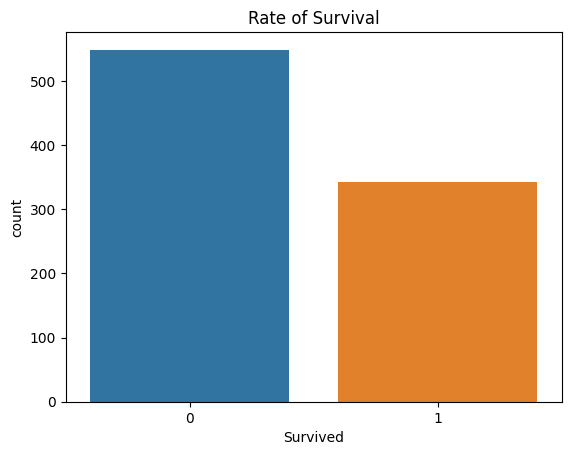

In [4]:
sns.countplot(data=df_train, x='Survived')
plt.title('Rate of Survival')
plt.show()

We see that most passengers didn't survive the sinking of the Titanic.

The difference between the number of passengers who survived and the ones who died is around two hunded.

## 2.4. Categorical Feature Analysis

Let's now consider the following categorical features: **Pclass**, **Sex**, **Embarked**, **Parch** and **SibSp**.

For now we will forget about **Cabin**, **Name** and **Ticket** because these have high cardinality and we might have trouble plotting them.

Let's look at how how survival rate varies by category:

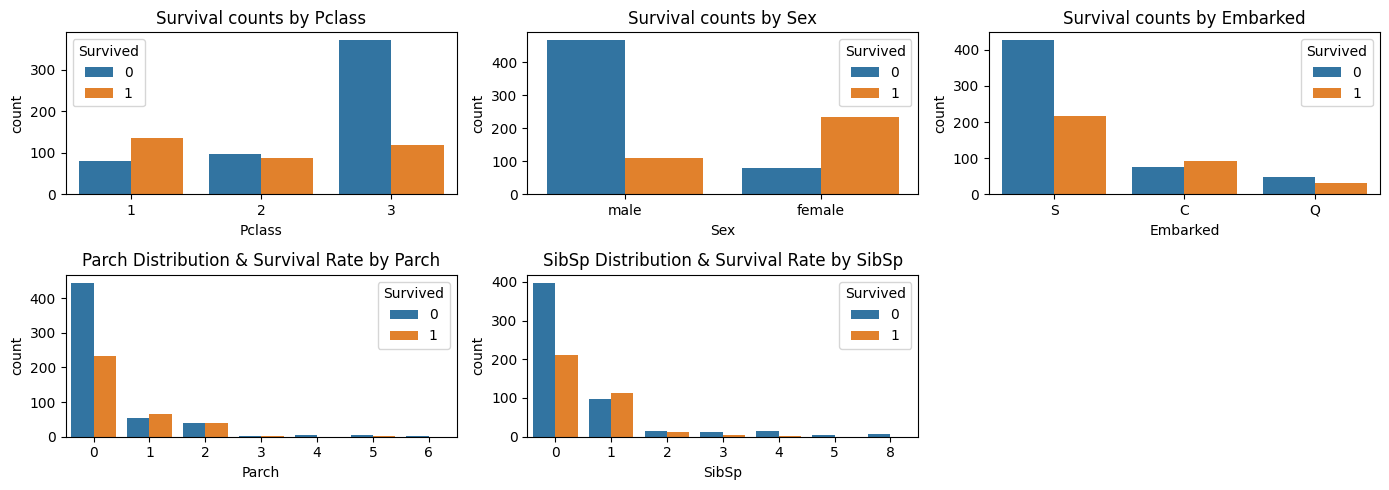

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(14, 5))

sns.countplot(data=df_train, x='Pclass', hue='Survived', ax=axs[0, 0])
axs[0, 0].set_title('Survival counts by Pclass')

sns.countplot(data=df_train, x='Sex', hue='Survived', ax=axs[0, 1])
axs[0, 1].set_title('Survival counts by Sex')

sns.countplot(data=df_train, x='Embarked', hue='Survived', ax=axs[0, 2])
axs[0, 2].set_title('Survival counts by Embarked')

sns.countplot(data=df_train, x='Parch', hue='Survived', ax=axs[1, 0])
axs[1, 0].set_title('Parch Distribution & Survival Rate by Parch')

sns.countplot(data=df_train, x='SibSp', hue='Survived', ax=axs[1, 1])
axs[1, 1].set_title('SibSp Distribution & Survival Rate by SibSp')

fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.show()

- We see the lowest rate of survival among third class passengers, and the highest one among first class passengers.
- As we hypothesized in section 1.2, rate of survival is very low among men and very high among women.
- We see a very low rate of survival among passengers who embarked on Southampton.
- We also see a low rate of survival among passengers who traveled alone and a higher one among those who had parents/children or siblings/spouses aboard.

## 2.5. Numerical Feature Analysis

Let's look at how survival varies among passengers by **Age**, **Fare**, **Parch** and **SibSp**:

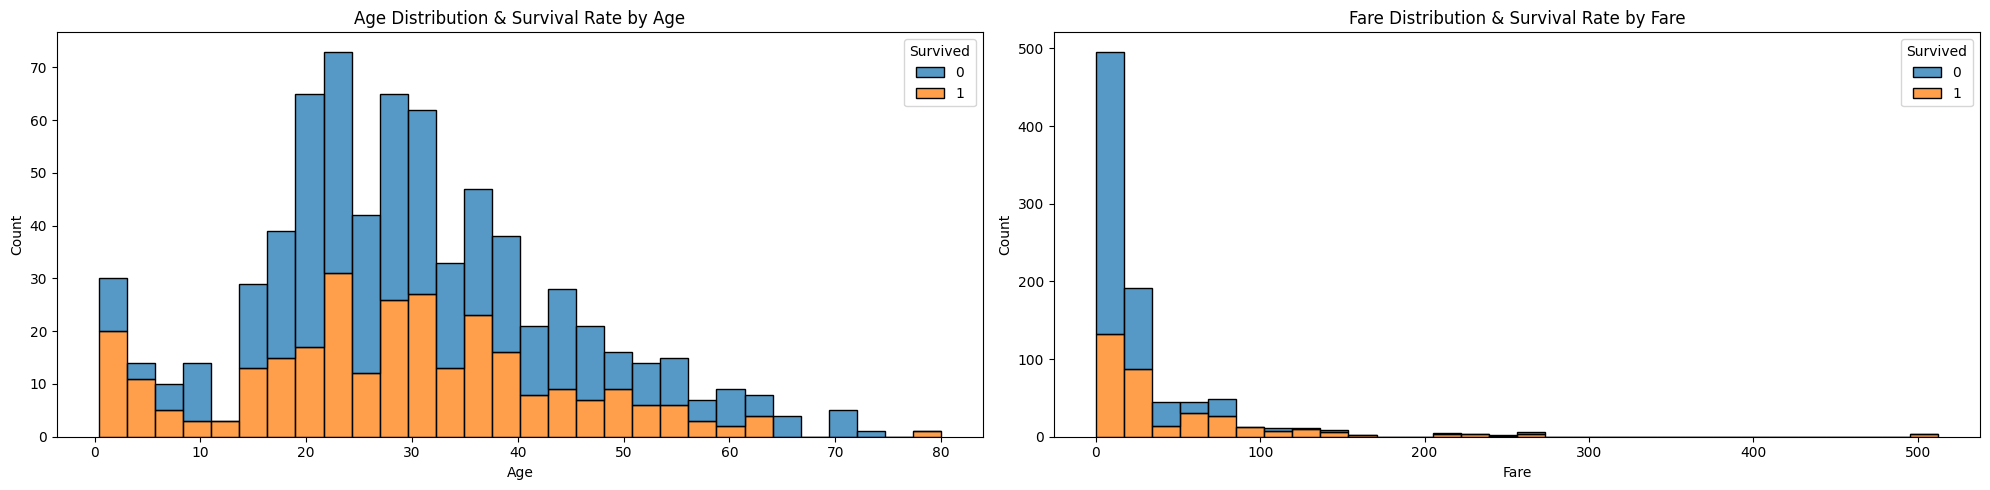

In [6]:
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(data=df_train, x='Age', hue='Survived', bins=30, multiple='stack', ax=axs[0])
axs[0].set_title('Age Distribution & Survival Rate by Age')

sns.histplot(data=df_train, x='Fare', hue='Survived', bins=30, multiple='stack', ax=axs[1])
axs[1].set_title('Fare Distribution & Survival Rate by Fare')

plt.tight_layout()
plt.show()

- Children aged 5 years and less have the highest survival rate of all passengers. The survival rate among other passengers doesn't change significantly. Most passengers were aged between 20 to 40.
- As we hypothesized, wealthy passangers have a highest rate of survival. Most passengers with low fare died. As fare increases, so does survival rate.

## 2.6. Correlation Matrix & Feature Analysis

Let's take a look at the correlation between our numerical features (**Age** and **Fare**) and our target.

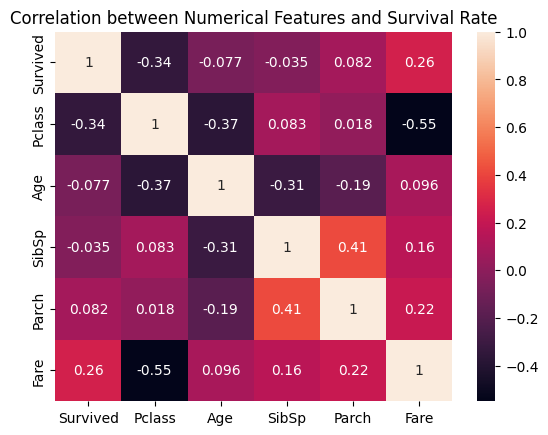

In [7]:
pre_numerical_cols = [cols for cols in df_train.columns if (df_train[cols].dtype in ['float', 'int']) and not(cols  in ['PassengerId', 'Survived'])]
pre_categorical_cols = [cols for cols in df_train.columns if (df_train[cols].dtype == 'object') and not(cols  in ['PassengerId', 'Survived'])]

sns.heatmap(data=df_train[['Survived'] + pre_numerical_cols].corr(), annot=True)
plt.title('Correlation between Numerical Features and Survival Rate')
plt.show()

- We see a relatively high positive correlation between **Fare** and **Survived**. It makes sense: the higher the fare, the higher the chance of survival.
- We also see a very negative correlation between **Pclass** and **Survived**. Intuitively, first class passengers have a higher chance of survival and as class goes up, survival rate goes down.

## 2.7. EDA Summary & Hypothesis Update

We have found that the features that have a greater affect on survival rate are the following:

- **Sex**. High survival rate among women and low survival rate among men.
- **Pclass**. First class passengers have a high survival rate while third class passengers have lowest survival rate.
- **Fare**. Survival rate is directly correlated with wealth - wealthier passengers have a higher chance of survival.
- **Parch** & **SibSp**. Passenger who traveled alone have a very low chance of surviving.

# 3. Preprocess Data

## 3.1. Data Cleaning

We will now set **PassengerId** as our index for both our training and testing DataFrames.

We will also drop columns we do not need like **Name** and **Ticket**.

The **Cabin** column will also be dropped because of its large amount of missing values.

The following code also defines the imputer we will use for our numerical features.

We will impute missing values by the median, which tends to work well with these data types.

In [8]:
#Set index
df_train = df_train.set_index('PassengerId')
df_test = df_test.set_index('PassengerId')

#Drop columns
df_train = df_train.drop(['Name', 'Ticket', 'Cabin'], axis=1)
df_test = df_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)

#Define imputer for numerical values
numerical_transformer = SimpleImputer(strategy='median')

## 3.2. Feature Engineering

Next we will create a couple of features that might be useful to predict our target:

- We will add a feature counting **FamilySize** for each passenger. We will do that by adding up Parch, SibSp and 1.
- **IsAlone** will tell us whether that passenger's family size is exactly 1. That means they traveled without parents/children and without siblings/spouse.

In [9]:
#Create FamilySize feature
df_train['FamilySize'] = df_train['Parch'] + df_train['SibSp'] + 1
df_test['FamilySize'] = df_test['Parch'] + df_test['SibSp'] + 1

#Create IsAlone feature
df_train['IsAlone'] = (df_train['FamilySize'] == 1).astype(int)
df_test['IsAlone'] = (df_test['FamilySize'] == 1).astype(int)

## 3.3. Encoding Categorical Variables

We will use One Hot Encoding for the columns containing object types.

Since we have a couple of missing values for **Embarked**, we will also need to define an imputer.

A most frequent strategy will be used for categorical feature imputation.

We will incorporate all these changes with a pipeline in a later section.

In [10]:
#Define imputer for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

## 3.4. Data Splitting

Next we will create a DataFrame called X containing the features we will use to make predictions.

The Pandas Series y will contain the target, **Survived**.

We will also split our training data into two subsets:

- One will be used for training the model.
- And the other will be used for model evaluation.

In [11]:
#Create target and features
y = df_train['Survived']
X = df_train.drop(['Survived'], axis=1)

#Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

## 3.5. Data Transformation Pipeline

Now we will define our pipeline and use it to transform all of our features.

In [12]:
#Define categorical columns and numerical columns
numerical_cols = [cols for cols in X.columns if X[cols].dtype in ['float', 'int']]
categorical_cols = [cols for cols in X.columns if X[cols].dtype in ['object']]

#Define our pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

#Fit pipeline on the training data
preprocessor.fit(X_train)

#Transform our features
X_train_pro = pd.DataFrame(preprocessor.transform(X_train),  columns=preprocessor.get_feature_names_out(), index=X_train.index)
X_valid_pro = pd.DataFrame(preprocessor.transform(X_valid), columns=preprocessor.get_feature_names_out(), index=X_valid.index)
df_test_pro = pd.DataFrame(preprocessor.transform(df_test), columns=preprocessor.get_feature_names_out(),index=df_test.index)

# 4. Build & Evaluate Model

## 4.1. Baseline Model (DummyClassifier)

First we will define a baseline model.

We will use DummyClassifier, which completely ignores all features to make predictions.

This will serve as a benchmark - we will build better models and compare them to this one.

In [13]:
dummy = DummyClassifier(random_state=0);

## 4.2. Train Multiple Models

In this step we will train three different models that tend to perform well on binary classification problems with structured data.

These are eXtreme Gradient Boosting (XGB), Random Forests and Logistic Regression.

We will set random state for reproducibility.

In [14]:
xgb = XGBClassifier(random_state=0);
random_forest = RandomForestClassifier(random_state=0);
logistic_regression = LogisticRegression(random_state=0);

## 4.3. Cross-Validation

For an initial comparison before hyperparemeter tuning, we will do cross-validation on our training data.

In [27]:
dummy_accuracy = cross_val_score(dummy, X_train_pro, y_train, cv=5, scoring='accuracy')
xgb_accuracy = cross_val_score(xgb, X_train_pro, y_train, cv=5, scoring='accuracy')
random_forest_accuracy = cross_val_score(random_forest, X_train_pro, y_train, cv=5, scoring='accuracy')
logistic_regression_accuracy = cross_val_score(logistic_regression, X_train_pro, y_train, cv=5, scoring='accuracy')

print("Dummy Cross-Validation Mean Accuracy: {}".format(dummy_accuracy.mean()))
print("XGB Cross-Validation Mean Accuracy: {}".format(xgb_accuracy.mean()))
print("Random Forest Cross-Validation Mean Accuracy: {}".format(random_forest_accuracy.mean()))
print("Logistic Regression Cross-Validation Mean Accuracy: {}".format(logistic_regression_accuracy.mean()))

Dummy Cross-Validation Mean Accuracy: 0.6165763813651137
XGB Cross-Validation Mean Accuracy: 0.8005614104205654
Random Forest Cross-Validation Mean Accuracy: 0.7837486457204768
Logistic Regression Cross-Validation Mean Accuracy: 0.7991726583275879


The models using XGB, Random Forest and Logistic Regression performed similarly while the Dummy model stayed behind, which makes sense.

## 4.4. Hyperparameter Tuning

In this step we will do a grid search using cross-validation to find good parameters for each of our models.

In [16]:
#Ignore UserWarning
warnings.simplefilter(action='ignore', category=UserWarning)

#Grid search for XGB
xgb_search = GridSearchCV(estimator=xgb,
                          param_grid={'n_estimators': [100, 200, 500],
                                      'max_depth': [3, 6, 10],
                                      'learning_rate': [0.01, 0.1, 0.3]},
                          scoring='accuracy')
xgb_search.fit(X_train_pro, y_train)

#Grid search for Random Forest
random_forest_search = GridSearchCV(estimator=random_forest, 
                                    param_grid={'n_estimators': [100, 200, 500],
                                                'max_depth': [None, 10, 20]},
                                    scoring='accuracy')
random_forest_search.fit(X_train_pro, y_train)

#Grid search for Logistic Regression
logistic_regression_search = GridSearchCV(estimator=logistic_regression,
                                          param_grid={'max_iter': [100, 500, 1000],
                                                      'C': [0.1, 1, 10],
                                                      'solver': ['liblinear', 'lbfgs', 'saga']},
                                          scoring='accuracy')
logistic_regression_search.fit(X_train_pro, y_train)

#Get the best models
xgb_model = xgb_search.best_estimator_
random_forest_model = random_forest_search.best_estimator_
logistic_regression_model = logistic_regression_search.best_estimator_

#Loot at the best parameters
print("XGB best parameters:", xgb_search.best_params_)
print("Random Forest best parameters:", random_forest_search.best_params_)
print("Logistic Regression best parameters:", logistic_regression_search.best_params_)

XGB best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Random Forest best parameters: {'max_depth': 10, 'n_estimators': 500}
Logistic Regression best parameters: {'C': 0.1, 'max_iter': 500, 'solver': 'lbfgs'}


## 4.5. Model Evaluation (Validation Set)

Now we will use the parameters found in the last section to make predictions on the validation data and get an accuracy score.

In [17]:
#Make predictions
xgb_preds = xgb_model.predict(X_valid_pro)
random_forest_preds = random_forest_model.predict(X_valid_pro)
logistic_regression_preds = logistic_regression_model.predict(X_valid_pro)

#Get accuracy
xgb_accuracy = accuracy_score(y_valid, xgb_preds)
random_forest_accuracy = accuracy_score(y_valid, random_forest_preds)
logistic_regression_accuracy = accuracy_score(y_valid, logistic_regression_preds)

print("XGB model accuracy on evaluation data: {}".format(xgb_accuracy))
print("Random Forest model accuracy on evaluation data: {}".format(random_forest_accuracy))
print("Logistic Regression model accuracy on evaluation data: {}".format(logistic_regression_accuracy))

XGB model accuracy on evaluation data: 0.8435754189944135
Random Forest model accuracy on evaluation data: 0.8547486033519553
Logistic Regression model accuracy on evaluation data: 0.7988826815642458


The models that performed best are XGB and Random Forest while the Logistic Regression model stays slightly behind.

Let's look at the confusion matrix for each model to see how the passengers were classified.

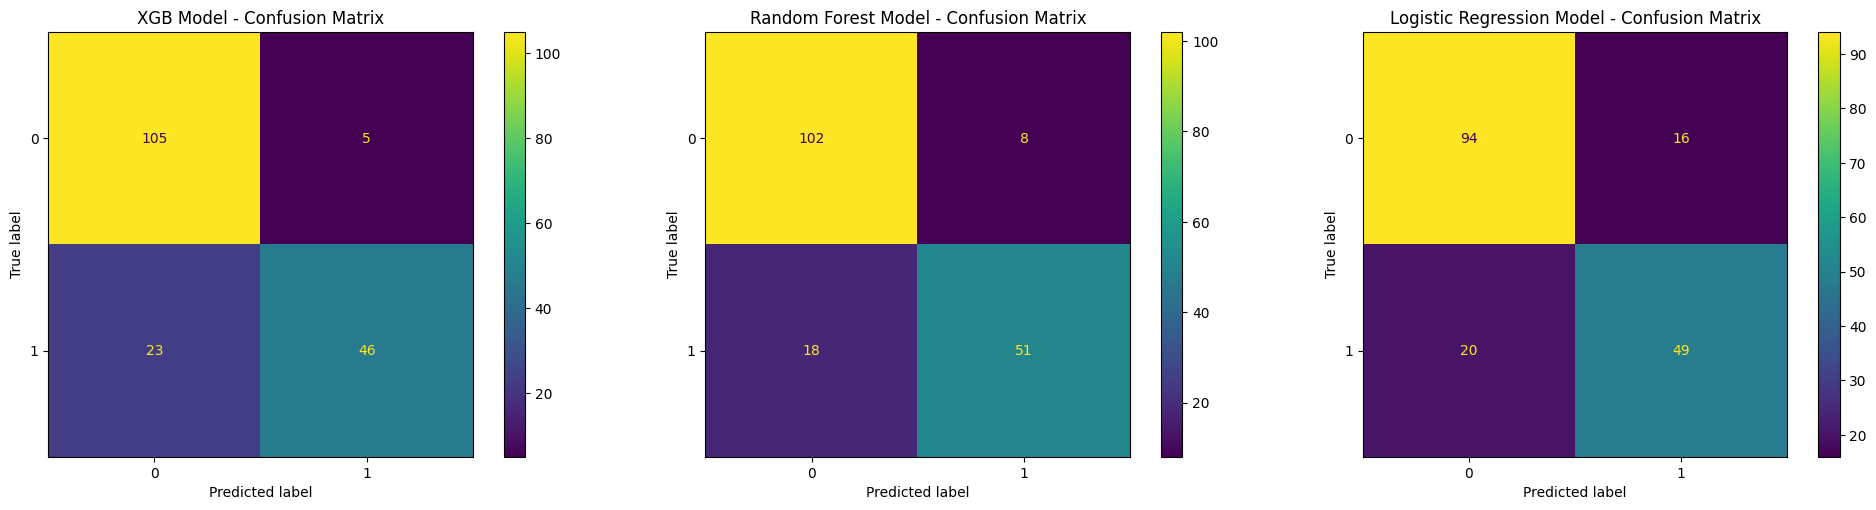

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

cm_xgb = confusion_matrix(y_valid, xgb_preds)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb).plot(ax=axs[0])
axs[0].set_title("XGB Model - Confusion Matrix")

cm_random_forest = confusion_matrix(y_valid, random_forest_preds)
disp_random_forest = ConfusionMatrixDisplay(confusion_matrix=cm_random_forest).plot(ax=axs[1])
axs[1].set_title("Random Forest Model - Confusion Matrix")

cm_logistic_regression = confusion_matrix(y_valid, logistic_regression_preds)
disp_logistic_regression = ConfusionMatrixDisplay(confusion_matrix=cm_logistic_regression).plot(ax=axs[2])
axs[2].set_title("Logistic Regression Model - Confusion Matrix")

plt.tight_layout()
plt.show()

The results indicate that we got:

- 23 false negatives using the XGB model.
- 18 false negatives using the Random Forest model.
- 20 false negatives using the Logistic Regression model.

These are passengers that the predictions say did not survive, when in fact they did survive.

Surprisingly, the XGB model, which had a high accuracy score on the validation data, got the most false negatives.

Let's look at the false positives we got:

- 5 false positives using the XGB model.
- 8 false positives using the Random Forest model.
- 16 false positives using the Logistic Regression model.

These are passengers that the predictions say did survive, when in fact they did not survive.

We notice XGB got very low false positives, which explains its high accuracy on the validation data.

The Logistic Regression model did a lot of mistakes for both, which explains why it got the lowest accuracy of all.

Let's look at the ROC curve and the AUC score for each model:

ROC curves:


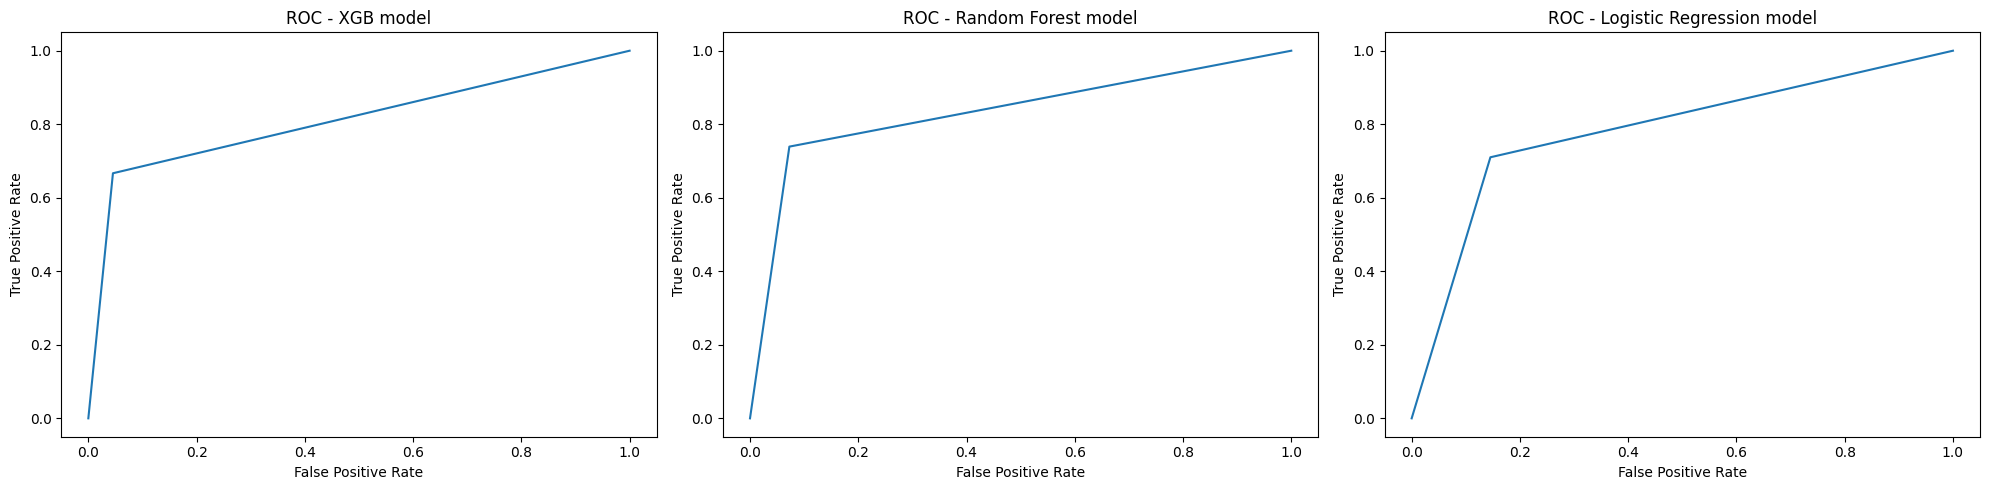




XGB model AUC score: 0.8106060606060606
Random Forest model AUC score: 0.833201581027668
Logistic Regression model AUC score: 0.7823451910408431


In [19]:
#Get ROC curve and AUC score for XGB
fpr_xgb, tpr_xgb, _ = roc_curve(y_valid, xgb_preds)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

#Get ROC curve and AUC score for Random Forest
fpr_random_forest, tpr_random_forest, _ = roc_curve(y_valid, random_forest_preds)
roc_auc_random_forest = auc(fpr_random_forest, tpr_random_forest)

#Get ROC curve and AUC score for Logistic Regression
fpr_logistic_regression, tpr_logistic_regression, _ = roc_curve(y_valid, logistic_regression_preds)
roc_auc_logistic_regression = auc(fpr_logistic_regression, tpr_logistic_regression)

#Plot ROC curves
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].plot(fpr_xgb, tpr_xgb)
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC - XGB model')

axs[1].plot(fpr_random_forest, tpr_random_forest)
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC - Random Forest model')

axs[2].plot(fpr_logistic_regression, tpr_logistic_regression)
axs[2].set_xlabel('False Positive Rate')
axs[2].set_ylabel('True Positive Rate')
axs[2].set_title('ROC - Logistic Regression model')

print("ROC curves:")
plt.tight_layout()
plt.show()

#Print AUC scores
print("\n\n")
print("XGB model AUC score: {}".format(roc_auc_xgb))
print("Random Forest model AUC score: {}".format(roc_auc_random_forest))
print("Logistic Regression model AUC score: {}".format(roc_auc_logistic_regression))

Remember that the ROC curve plots the True Positive Rate against the False Positive Rate when varying the classification threshold.

The AUC score is the area below the ROC curve.

The AUC score of the Random Forest model is slightly better than that of the XGB model, while Logistic Regression stays behind.

## 4.6. Model Comparison Summary

Let's sum up by making a visual comparison between our models' performances.

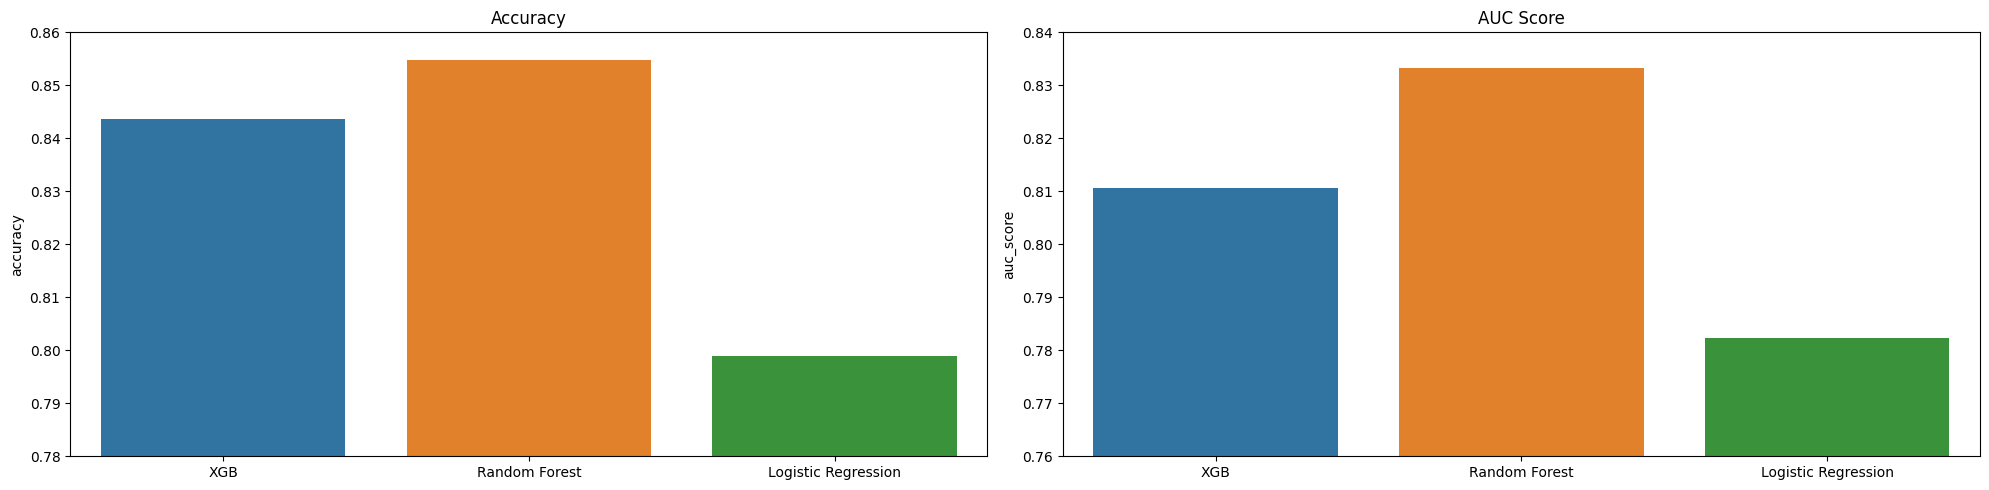

In [20]:
#Create scores Pandas DataFrame
scores = pd.DataFrame({'accuracy': [xgb_accuracy, random_forest_accuracy, logistic_regression_accuracy],
                      'auc_score': [roc_auc_xgb, roc_auc_random_forest, roc_auc_logistic_regression]},
                      index=['XGB', 'Random Forest', 'Logistic Regression'])

#Plot
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

sns.barplot(x=scores.index, y=scores.accuracy, ax=axs[0])
axs[0].set_ylim([0.78, 0.86])
axs[0].set_title('Accuracy')

sns.barplot(x=scores.index, y=scores.auc_score, ax=axs[1])
axs[1].set_ylim([0.76, 0.84])
axs[1].set_title('AUC Score')

plt.tight_layout()
plt.show()

Since we got both the highest accuracy on the validation data and the highest AUC score with the Random Forest model, that is the model we will use to make the predictions for the Competition.

This is surprising because XGB usually performs better than XGB.

This could be due to the nature of the relationships between the target and the features, which could be captured better by the Random Forest model.

Another reason could be because our dataset is small - we only have information for 891 passengers on the training data.

# 5. Predict & Submit

## 5.1. Retrain Best Model on Full Training Data

Before making predictions for the testing data we will fit the Random Forest model on the full training data.

In [21]:
#Preprocess full training data
X_pro = pd.DataFrame(preprocessor.transform(X),  columns=preprocessor.get_feature_names_out(), index=X.index)

#Fit Random Forest on full training data
random_forest_search.fit(X_pro, y)
final_model = random_forest_search.best_estimator_

#Look at best parameters
print("Best parameters:", random_forest_search.best_params_)

Best parameters: {'max_depth': 10, 'n_estimators': 500}


## 5.2. Predict on Test Set & Create Submission File

Now we will make predictions on the testing data and create the submission file for the competition.

In [22]:
output = pd.DataFrame({'PassengerId': df_test.index, 'Survived': final_model.predict(df_test_pro)})
output.to_csv('submission.csv', index=False)

## 5.3. Feature Importance Plot for Final Model

Let's look at which features our final model considered to be most important for predicting survival rate.

In section 2.6 we hypothesized that **Sex**, **Fare**, **Pclass** would be the most important, followed by **Parch** and **SibSp**.

Since we noticed that passengers who traveled alone had a lower rate of survival, we introduced **FamilySize** and **IsAlone**, which we thought would also be important.

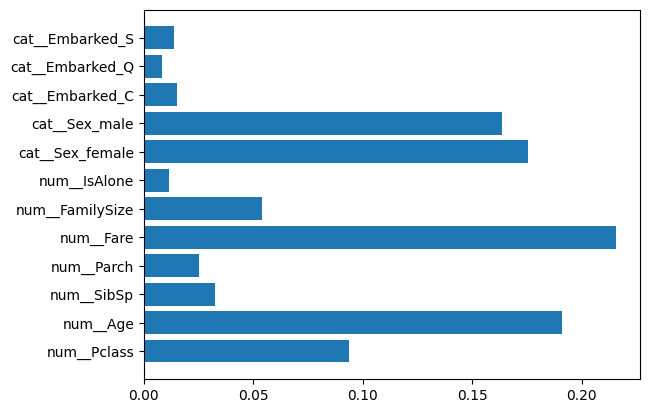

In [23]:
features = list(X_pro.columns)
importances = list(final_model.feature_importances_)
plt.barh(y=features, width=importances)
plt.show()

The results match our hypothesis very well.

In order, the features that our Random Forest model considered most important are: **Fare**, **Age**, **Sex**, **Pclass** and **FamilySize**.

We did not predict that **Age** would be so important though.

In section 2.5 we observed that children had a significantly higher rate of survival.

This information was certainly captured by our model.

## 5.4. Conclusions & Learnings

The most important features to predict whether a passenger survived or not in the Titanic sinking, and how they do so are as follow:

- **Fare**. Wealth is directly correlated to survival rate.
- **Age**. Children had a high chance of surviving. Beyond children, age doesn't seem to affect survival rate that much though.
- **Sex**. Women had significantly higher chances of surviving than men.
- **Pclass**. The highest rate of survival is seen among first class passengers. Third class passengers had the lowest chances of surviving.
- **Family size** is directly correlated to survival rate.

We used a Random Forest model, which slightly outperformed XGB, while Logistic Regression stayed behind.

This is surprising because XGB usually performs better than Random Forest.

This could be happening for a couple reasons:

- The nature of the relationships between the target and the features.
- Our dataset is small.

All in all, this was my first project and I am very happy how it went.

This simple classifying problem served as an introduction to supervised learning, and I hope to do more complicated projects in the future.

Thanks for reading!